# Assignment 4

## Part 2
**Objective**<br>
Run multinomial Naive Bayes on LES dataset. Examine distribution profiles. Are we making a big mistake in assuming Gaussian profiles?

## 1. Importing Libraries

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from collections import Counter
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import pickle
%matplotlib inline

## 2. Reading dataset

Combining the data from 3 files into a single dataframe

In [6]:
import os
owd = os.getcwd()
print(owd)
# os.chdir("../../")
print(os.getcwd())

/Users/sayalidalvi/Documents/Neural/Submissions/Assignment_4/Assignment4_Group1
/Users/sayalidalvi/Documents/Neural/Submissions/Assignment_4/Assignment4_Group1


In [7]:

all_filenames = ['MI_14840_2013Fall_2014Spring.csv', 'IL_94846_2013Fall_2014Spring.csv', 'IN_04846_2013Fall_2014Spring.csv']
combined_df = pd.concat([pd.read_csv(f) for f in all_filenames ])
combined_df.shape

(13106, 37)

## 3. Exploratory Data Analysis

In [8]:
combined_df.describe()

,Date_CST,Date_UTC_x,Mean,Centroid_lon,Centroid_lat,Std_lon,Std_lat,Skewness_lon,Skewness_lat,Kurtosis_lon,Kurtosis_lat,Sample Number,Date_UTC_y
count,1.310600e+04,1.298900e+04,12989.000000,12989.000000,12989.000000,12989.000000,12989.000000,12989.000000,12989.000000,12989.000000,12989.000000,12989.000000,1.308800e+04
mean,2.013562e+07,2.013562e+07,0.148573,-86.727683,43.903335,0.638893,1.226346,0.633695,0.049575,2.997538,1.755656,3.584957,2.013562e+07
std,4.550503e+03,4.550328e+03,0.210322,0.074443,0.154487,0.028038,0.040396,0.103133,0.176347,0.268156,0.155322,0.573347,4.550409e+03
min,2.013100e+07,2.013100e+07,0.000812,-87.149116,42.731292,0.389177,0.622282,-0.052495,-1.043359,1.935527,1.410064,2.000000,2.013100e+07
25%,2.013112e+07,2.013112e+07,0.002022,-86.753979,43.856188,0.627495,1.213378,0.598284,-0.002125,2.876907,1.695506,3.000000,2.013112e+07
50%,2.013123e+07,2.013123e+07,0.002597,-86.733668,43.906035,0.640340,1.230380,0.637681,0.045102,2.973936,1.724313,4.000000,2.013123e+07
75%,2.014021e+07,2.014021e+07,0.290841,-86.710415,43.949028,0.651723,1.244278,0.678651,0.102470,3.089843,1.764506,4.000000,2.014021e+07
max,2.014033e+07,2.014033e+07,0.956265,-86.340049,44.699625,0.818549,1.467391,1.382664,2.265091,6.377330,6.867313,4.000000,2.014033e+07


### a. Dropping redundant Date Time columns

We will keep only one column relevant to date and time and drop others

In [9]:
remove_col = ['Date_CST', 'Time_CST',
              'Date_UTC_x', 'Time_UTC_x','Date_UTC_y', 'Time_UTC_y']
combined_df = combined_df.drop(remove_col, axis = 1) 
combined_df = combined_df.reset_index(drop=True)

Renaming column names by replacing spaces by underscores and removing brackets 

In [10]:
combined_df.columns = combined_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
combined_df.columns

/var/folders/pw/kjv2697x6q18wbdd7j7x8w_00000gn/T/ipykernel_24226/1553413785.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  combined_df.columns = combined_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
/var/folders/pw/kjv2697x6q18wbdd7j7x8w_00000gn/T/ipykernel_24226/1553413785.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  combined_df.columns = combined_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')


Index(['date', 'time', 'temp_f', 'rh_%', 'dewpt_f', 'wind_spd_mph',
       'wind_direction_deg', 'peak_wind_gustmph', 'low_cloud_ht_ft',
       'med_cloud_ht_ft', 'high_cloud_ht_ft', 'visibility_mi', 'atm_press_hpa',
       'sea_lev_press_hpa', 'altimeter_hpa', 'precip_in', 'wind_chill_f',
       'heat_index_f', 'mean', 'centroid_lon', 'centroid_lat', 'std_lon',
       'std_lat', 'skewness_lon', 'skewness_lat', 'kurtosis_lon',
       'kurtosis_lat', 'sample_number', 'selected', 'lake_visible',
       'les_exist'],
      dtype='object')

### b. Dropping column containing noisy data

Now let's take a look at unique values in the dataset. We will print all the unique values in each column

In [11]:
for var in combined_df.columns:
    print(combined_df[var].unique())

['2013-10-01' '2013-10-02' '2013-10-03' '2013-10-04' '2013-10-05'
 '2013-10-06' '2013-10-07' '2013-10-08' '2013-10-09' '2013-10-10'
 '2013-10-11' '2013-10-12' '2013-10-13' '2013-10-14' '2013-10-15'
 '2013-10-16' '2013-10-17' '2013-10-18' '2013-10-19' '2013-10-20'
 '2013-10-21' '2013-10-22' '2013-10-23' '2013-10-24' '2013-10-25'
 '2013-10-26' '2013-10-27' '2013-10-28' '2013-10-29' '2013-10-30'
 '2013-10-31' '2013-11-01' '2013-11-02' '2013-11-03' '2013-11-04'
 '2013-11-05' '2013-11-06' '2013-11-07' '2013-11-08' '2013-11-09'
 '2013-11-10' '2013-11-11' '2013-11-12' '2013-11-13' '2013-11-14'
 '2013-11-15' '2013-11-16' '2013-11-17' '2013-11-18' '2013-11-19'
 '2013-11-20' '2013-11-21' '2013-11-22' nan '2013-11-23' '2013-11-24'
 '2013-11-25' '2013-11-26' '2013-11-27' '2013-11-28' '2013-11-29'
 '2013-11-30' '2013-12-01' '2013-12-02' '2013-12-03' '2013-12-04'
 '2013-12-05' '2013-12-06' '2013-12-07' '2013-12-08' '2013-12-09'
 '2013-12-10' '2013-12-11' '2013-12-12' '2013-12-13' '2013-12-14'
 '2013

We observe that there are some irrelevant values like 'M','m' and 'NC'. We don't need these. <br>
So we will replace these noisy values by NaN and further check how many total nulls are present in each column

In [12]:
combined_df.replace('m', np.nan, inplace=True)
combined_df.replace('M', np.nan, inplace=True)
combined_df.replace('NC', np.nan, inplace=True)
combined_df.isnull().sum()

date                     12
time                     12
temp_f                   83
rh_%                     94
dewpt_f                  94
wind_spd_mph             38
wind_direction_deg       97
peak_wind_gustmph     10530
low_cloud_ht_ft        2874
med_cloud_ht_ft        8904
high_cloud_ht_ft      11859
visibility_mi            20
atm_press_hpa            28
sea_lev_press_hpa       828
altimeter_hpa            23
precip_in               629
wind_chill_f           3206
heat_index_f          13103
mean                    117
centroid_lon            117
centroid_lat            117
std_lon                 117
std_lat                 117
skewness_lon            117
skewness_lat            117
kurtosis_lon            117
kurtosis_lat            117
sample_number           117
selected                117
lake_visible             18
les_exist                18
dtype: int64

We would now elimate the columns having highest number of nulls.
The top 5 columns having noisy data are - `peak_wind_gustmph`, `high_cloud_ht_ft`, `heat_index_f`, `med_cloud_ht_ft`, `wind_chill_f`, `low_cloud_ht_ft` and `sea_lev_press_hpa`. <br>
So we will drop these columns.

In [13]:
combined_df = combined_df.drop(['peak_wind_gustmph', 'high_cloud_ht_ft', 'heat_index_f', 
                                'med_cloud_ht_ft','wind_chill_f', 'low_cloud_ht_ft',
                               'sea_lev_press_hpa'], axis = 1)
combined_df.shape

(13106, 24)

### c. Dropping null rows from the dataset

Let's now drop all the null rows in the remaining dataset

In [14]:
# Dropping nulls
combined_df = combined_df.dropna()
combined_df = combined_df.reset_index(drop = True)
combined_df.isnull().sum()

date                  0
time                  0
temp_f                0
rh_%                  0
dewpt_f               0
wind_spd_mph          0
wind_direction_deg    0
visibility_mi         0
atm_press_hpa         0
altimeter_hpa         0
precip_in             0
mean                  0
centroid_lon          0
centroid_lat          0
std_lon               0
std_lat               0
skewness_lon          0
skewness_lat          0
kurtosis_lon          0
kurtosis_lat          0
sample_number         0
selected              0
lake_visible          0
les_exist             0
dtype: int64

Now we don't have nulls in the data. Let's again look at the data to see if we are having any other problems

In [15]:
for var in combined_df.columns:
    print(combined_df[var].value_counts())

2013-11-07    72
2013-11-30    72
2013-10-27    72
2014-03-26    72
2013-11-10    72
              ..
2014-03-07    55
2014-03-31    53
2014-01-17    52
2014-01-14    46
2014-01-15    36
Name: date, Length: 182, dtype: int64
17:51    185
12:51    183
16:51    183
15:51    183
20:51    183
        ... 
22:52      1
21:50      1
12:52      1
09:50      1
06:01      1
Name: time, Length: 123, dtype: int64
34     316
24     301
23     296
20     295
19     294
      ... 
78       4
80       3
-16      3
79       3
81       2
Name: temp_f, Length: 98, dtype: int64
64    368
67    344
73    341
72    337
76    334
     ... 
25      4
94      4
24      3
27      2
23      1
Name: rh_%, Length: 75, dtype: int64
28     362
27     353
29     344
26     334
30     326
      ... 
-25      3
-27      3
-26      2
70       2
-24      1
Name: dewpt_f, Length: 98, dtype: int64
8     1112
9     1040
7      995
10     958
11     929
6      880
13     810
5      761
0      750
14     688
15     644
3    

Here we observe that `selected` column is having just one single value, so we can drop it as it doesn't add any information to our dataset

In [16]:
combined_df = combined_df.drop('selected', axis = 1)

### d. Converting categorial data to numeric

Next we will convert the categorical labels `lake_visible` and `les_exist` to numeric

In [17]:
combined_df['lake_visible'] = combined_df['lake_visible'].replace(to_replace=r'Y', value=r'1', regex=True)
combined_df['lake_visible'] = combined_df['lake_visible'].replace(to_replace=r'N', value=r'0', regex=True)
combined_df['les_exist'] = combined_df['les_exist'].replace(to_replace=r'Y', value=r'1', regex=True)
combined_df['les_exist'] = combined_df['les_exist'].replace(to_replace=r'N', value=r'0', regex=True)

In [18]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12211 entries, 0 to 12210
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                12211 non-null  object 
 1   time                12211 non-null  object 
 2   temp_f              12211 non-null  object 
 3   rh_%                12211 non-null  object 
 4   dewpt_f             12211 non-null  object 
 5   wind_spd_mph        12211 non-null  object 
 6   wind_direction_deg  12211 non-null  object 
 7   visibility_mi       12211 non-null  object 
 8   atm_press_hpa       12211 non-null  object 
 9   altimeter_hpa       12211 non-null  object 
 10  precip_in           12211 non-null  object 
 11  mean                12211 non-null  float64
 12  centroid_lon        12211 non-null  float64
 13  centroid_lat        12211 non-null  float64
 14  std_lon             12211 non-null  float64
 15  std_lat             12211 non-null  float64
 16  skew

Now we will convert all the data types to numeric

In [19]:
combined_df.iloc[:,2:] = combined_df.iloc[:,2:].apply(lambda x : pd.to_numeric(x , errors = 'coerce'))
combined_df.dtypes

date                   object
time                   object
temp_f                  int64
rh_%                    int64
dewpt_f                 int64
wind_spd_mph            int64
wind_direction_deg      int64
visibility_mi           int64
atm_press_hpa         float64
altimeter_hpa         float64
precip_in             float64
mean                  float64
centroid_lon          float64
centroid_lat          float64
std_lon               float64
std_lat               float64
skewness_lon          float64
skewness_lat          float64
kurtosis_lon          float64
kurtosis_lat          float64
sample_number         float64
lake_visible            int64
les_exist               int64
dtype: object

## 4. Adding Target Column

Adding the target column (LES_SNOWFALL) to the dataset.
Condition = if Temp < 32 and Precip > 0 then Y (1) else N (0)

In [20]:
combined_df['les_snowfall'] = np.where((combined_df['temp_f'] <= 32) & (combined_df['precip_in'] > 0), 1, 0)

We will also drop Temp and Precip columns to prevent the bias in the model

In [21]:
combined_df = combined_df.drop(['temp_f','precip_in'], axis = 1) 
combined_df.head()

,date,time,rh_%,dewpt_f,wind_spd_mph,wind_direction_deg,visibility_mi,atm_press_hpa,altimeter_hpa,mean,...,std_lon,std_lat,skewness_lon,skewness_lat,kurtosis_lon,kurtosis_lat,sample_number,lake_visible,les_exist,les_snowfall
0,2013-10-01,00:55,77,51,8,160,10,989.9,1012.9,0.001979,...,0.665668,1.226432,0.582646,0.007014,2.816020,1.711882,3.0,0,0,0
1,2013-10-01,01:55,80,52,6,160,10,990.2,1013.2,0.002175,...,0.670232,1.239065,0.660357,0.030175,2.863913,1.689899,4.0,0,0,0
2,2013-10-01,02:55,86,53,5,160,10,990.2,1013.2,0.007346,...,0.649593,1.235327,0.630409,0.023720,2.893504,1.712862,4.0,0,0,0
3,2013-10-01,03:55,86,59,9,190,10,990.2,1013.2,0.001971,...,0.656606,1.235076,0.614300,0.024125,2.869601,1.716328,3.0,0,0,0
4,2013-10-01,04:55,86,60,9,190,10,990.2,1013.2,0.008081,...,0.625056,1.225389,0.684025,0.192531,3.150438,1.765415,4.0,0,0,0


In [22]:
from collections import Counter
cnt = Counter(combined_df['les_snowfall'])
cnt

Counter({0: 11637, 1: 574})

The data is quite imbalanced.

## 5. Balancing the dataset

If there is a snowfall on any one hour of the day, we can assume that there waw snow falling for that "day".<br>
So we will extract all the dates in `dates_snowfall` where these was snowfall for any hour of the day, and then assign the `target_snow` column as 1 for all the rows for that day.

In [23]:
dates_snowfall = set()
for index,row in combined_df.iterrows():
    if row['les_snowfall']==1:
        dates_snowfall.add(row['date'])


In [24]:
combined_df['target_snow'] = np.where(combined_df['date'].isin(dates_snowfall),1,0)

Checking for one of the dates

In [25]:
combined_df[combined_df['date']=='2014-03-24'][['date','les_snowfall','target_snow']]

,date,les_snowfall,target_snow
3828,2014-03-24,0,1
3829,2014-03-24,0,1
3830,2014-03-24,0,1
3831,2014-03-24,0,1
3832,2014-03-24,1,1
...,...,...,...
12052,2014-03-24,0,1
12053,2014-03-24,0,1
12054,2014-03-24,0,1
12055,2014-03-24,0,1


Now let's check the distribution of the new target variable

In [26]:
cnt = Counter(combined_df['target_snow'])
cnt

Counter({0: 7144, 1: 5067})

## 6. Feature Engineering

### a. Correlation

<AxesSubplot:>

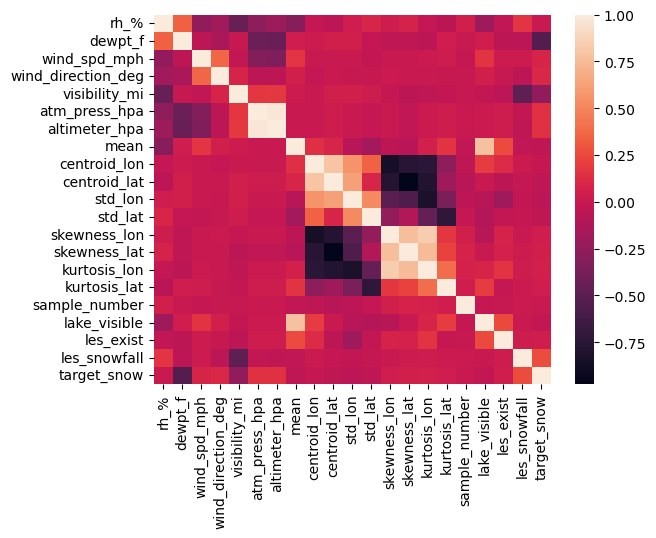

In [27]:
corr = combined_df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values )

### b. Dropping highly correlated features
Removing `centroid_lon`, `centroid_lat` and `atm_press_hpa` due it's high correlation with other columns

In [28]:
combined_df = combined_df.drop(['centroid_lon', 'centroid_lat','atm_press_hpa'], axis = 1)
combined_df.shape

(12211, 20)

### c. Feature Distribution
Now let's look at the distribution of each column by plotting the histogram

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


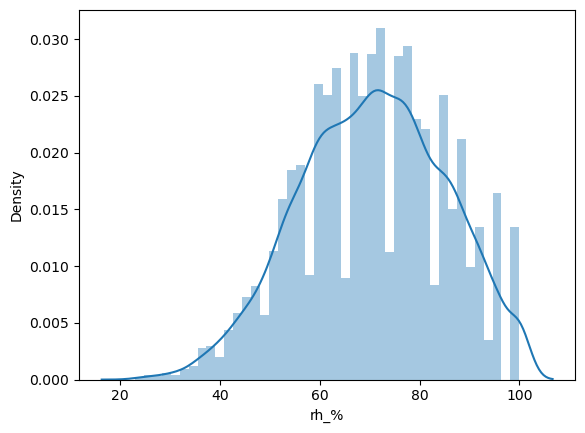

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


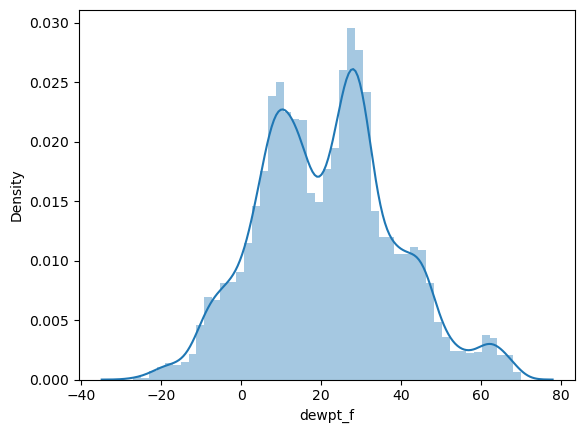

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


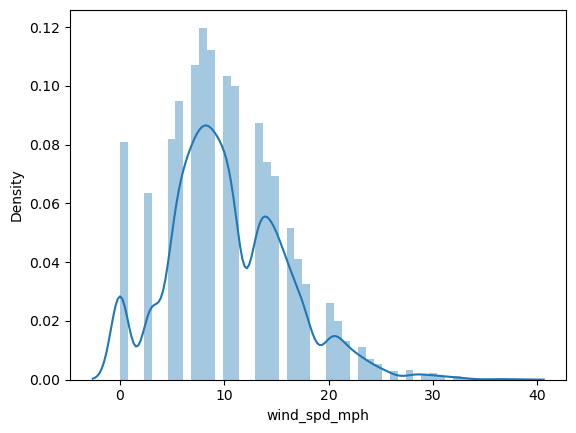

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


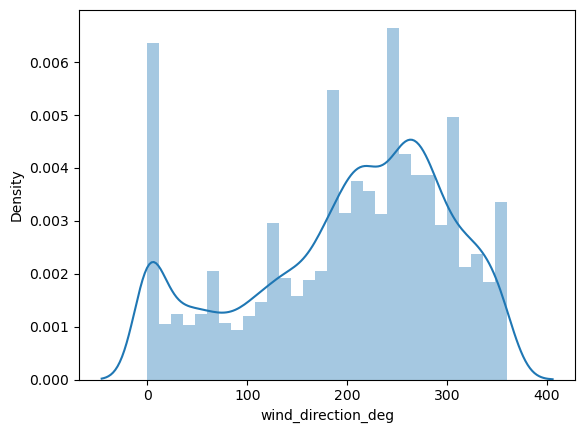

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


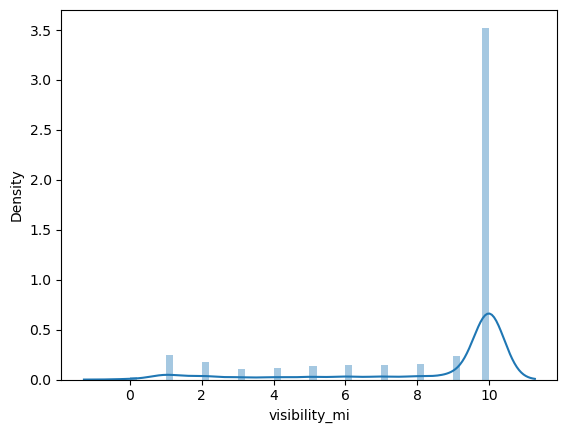

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


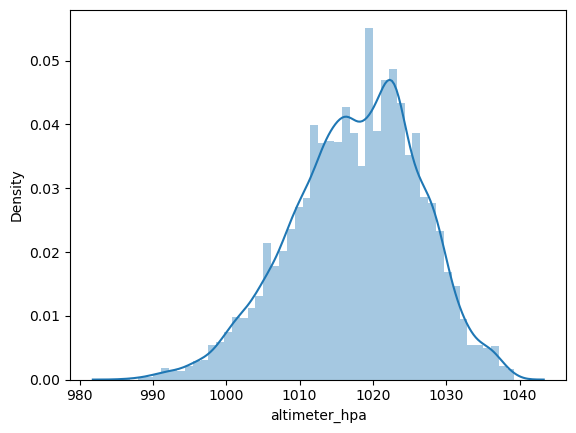

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


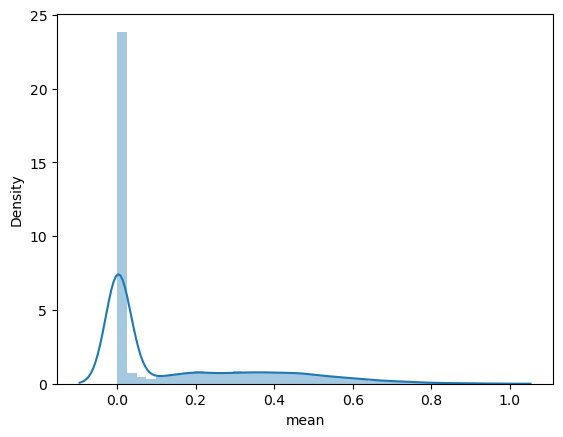

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


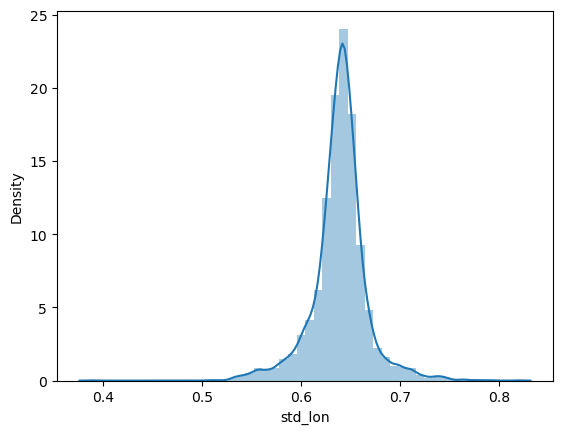

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


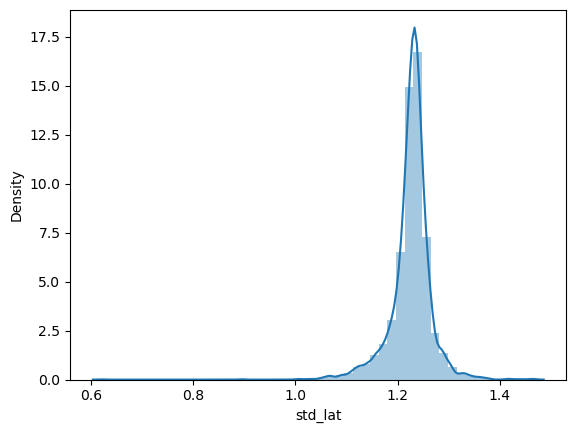

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


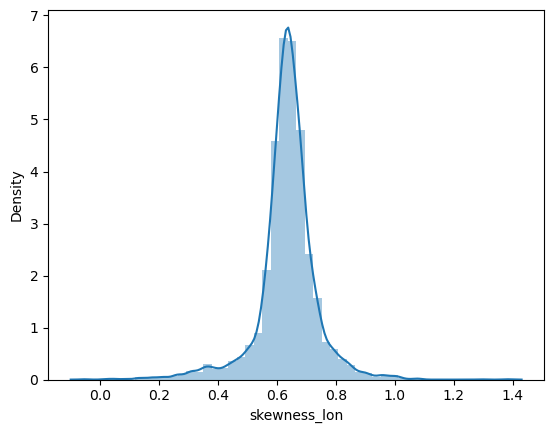

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


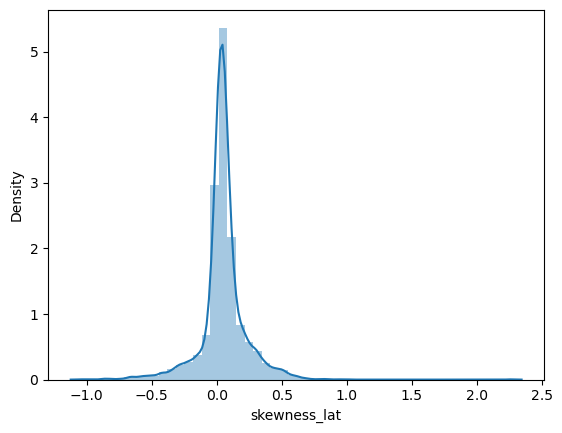

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


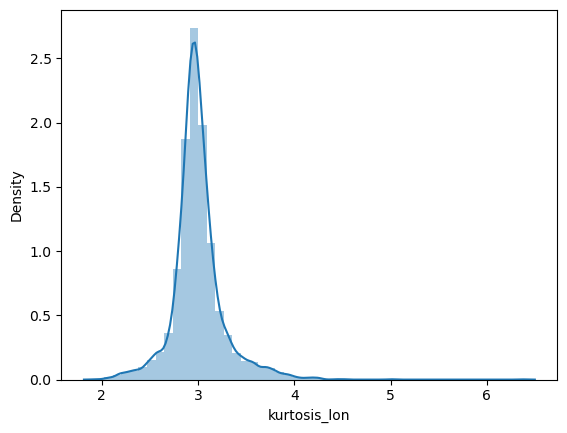

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


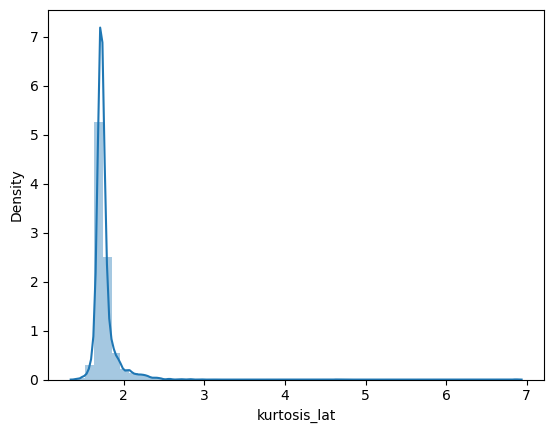

In [29]:
def distPlot(data):
    for feature in data:
        sns.distplot(data[feature])
        plt.show()
        
distPlot(combined_df.iloc[:,2:-5])

We could observe that some of them are normally distributed but some are not even close to a gaussian.

## 6. Shifting the dataframe to predict 3 days prior

As we want to predict the snowfall some days in advance, we will shift the target column.

In [30]:
def shift_col_hrs(data, hours):
    data3 = data.copy()
    data3['target_snow'] = data.target_snow.shift(-hours)
    data3 = data3.dropna()
    data3 = data3.reset_index(drop=True)
    return data3

Shifting the target column by 3 days i.e 72 hours

In [31]:
s_df = shift_col_hrs(combined_df,72)
print(s_df.shape)
s_df.tail()

(12139, 20)


,date,time,rh_%,dewpt_f,wind_spd_mph,wind_direction_deg,visibility_mi,altimeter_hpa,mean,std_lon,std_lat,skewness_lon,skewness_lat,kurtosis_lon,kurtosis_lat,sample_number,lake_visible,les_exist,les_snowfall,target_snow
12134,2014-03-28,09:53,85,33,11,330,10,1013.9,0.157507,0.725922,1.285263,0.682237,-0.050281,2.783454,1.661981,3.0,1,0,0,0.0
12135,2014-03-28,10:53,75,31,16,330,10,1015.9,0.158266,0.735719,1.286296,0.666183,-0.084224,2.721380,1.668370,4.0,1,0,0,0.0
12136,2014-03-28,11:53,72,29,9,340,10,1017.6,0.167383,0.733378,1.278658,0.656385,-0.080240,2.727861,1.673418,4.0,1,0,0,0.0
12137,2014-03-28,12:53,69,30,8,10,10,1018.3,0.179933,0.723208,1.277780,0.660659,-0.032906,2.770232,1.656046,3.0,1,0,0,0.0
12138,2014-03-28,13:53,67,30,6,10,10,1019.0,0.192494,0.707747,1.272414,0.672086,0.024177,2.845752,1.652426,4.0,1,0,0,0.0


## 7. Declare feature vector and target variable

In [32]:
s_df.columns

Index(['date', 'time', 'rh_%', 'dewpt_f', 'wind_spd_mph', 'wind_direction_deg',
       'visibility_mi', 'altimeter_hpa', 'mean', 'std_lon', 'std_lat',
       'skewness_lon', 'skewness_lat', 'kurtosis_lon', 'kurtosis_lat',
       'sample_number', 'lake_visible', 'les_exist', 'les_snowfall',
       'target_snow'],
      dtype='object')

In [33]:
X_dev = ['rh_%', 'dewpt_f', 'wind_spd_mph', 'wind_direction_deg',
       'visibility_mi', 'altimeter_hpa', 'mean', 'std_lon', 'std_lat',
       'skewness_lon', 'skewness_lat', 'kurtosis_lon', 'kurtosis_lat',
       'sample_number', 'lake_visible', 'les_exist']

In [34]:
X = pd.DataFrame(s_df , columns = X_dev)
print("Independant variables : ")
print(X.columns)
y = s_df['target_snow']
print("Dependant variable : target_snow")

Independant variables : 
Index(['rh_%', 'dewpt_f', 'wind_spd_mph', 'wind_direction_deg',
       'visibility_mi', 'altimeter_hpa', 'mean', 'std_lon', 'std_lat',
       'skewness_lon', 'skewness_lat', 'kurtosis_lon', 'kurtosis_lat',
       'sample_number', 'lake_visible', 'les_exist'],
      dtype='object')
Dependant variable : target_snow


### Scaling the feature set

In [35]:
from sklearn import preprocessing
X = preprocessing.scale(X)

## 8. Splitting into train and test dataset

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [37]:
X_train.shape, y_train.shape

((9711, 16), (9711,))

## 9. Fitting to Naive Bayes

In [38]:
from sklearn.naive_bayes import GaussianNB

nb1 = GaussianNB()
nb1.fit(X_train, y_train)

GaussianNB()

In [39]:
from sklearn.metrics import confusion_matrix, accuracy_score

pred1 = nb1.predict(X_test)
cm1 = confusion_matrix(pred1, y_test)
cm1

array([[848, 210],
       [606, 764]])

In [40]:
accuracy_score(pred1, y_test)

0.6639209225700164

### Decision Tree

In [41]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
pred = dt.predict(X_test)

print(confusion_matrix(pred, y_test))
accuracy_score(pred, y_test)

[[1195  219]
 [ 259  755]]


0.8031301482701813

### Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print(confusion_matrix(pred, y_test))
accuracy_score(pred, y_test)

[[1303  133]
 [ 151  841]]


0.8830313014827018

## 10. Conclusion
The accuracy of Naive Bayes model is 66% which is low as compared to decision trees (79%) and Random Forest (88%).
In Naive Bayes we are assuming the normal distribution of the data which might be causing the model to underperform.
We could clearly see that the features are not following the gaussian distribution. 
Hence, using Naive Bayes on this dataset is not justifiable.

# Approach 2

In order to balance the dataset we said that the whole day will have snowfall if it snows just for an hour in that day.
Let's try to group by `date` by taking mean of other features and try to fit our model to this dataset.

In [43]:
combined_df.shape

(12211, 20)

## Dropping the 'time' column

In [44]:
combined_df= combined_df.drop(['time'], axis = 1)

## Grouping by date
Excluding the target variable while grouping

In [45]:
grouped_df = combined_df.iloc[:,:-1].groupby('date').mean()
grouped_df.shape

(182, 17)

In [46]:
grouped_df.head()

,rh_%,dewpt_f,wind_spd_mph,wind_direction_deg,visibility_mi,altimeter_hpa,mean,std_lon,std_lat,skewness_lon,skewness_lat,kurtosis_lon,kurtosis_lat,sample_number,lake_visible,les_exist,les_snowfall
date,,,,,,,,,,,,,,,,,
2013-10-01,79.557143,60.942857,12.085714,211.428571,8.871429,1013.894286,0.152278,0.621409,1.204077,0.702741,0.158513,3.207811,1.826350,3.585714,0.471429,0.0,0.0
2013-10-02,62.621212,52.030303,3.787879,89.545455,9.257576,1017.440909,0.137656,0.665747,1.220560,0.486300,-0.205797,2.674225,1.914476,3.590909,0.469697,0.0,0.0
2013-10-03,85.095238,62.222222,7.285714,164.603175,7.920635,1014.007937,0.159178,0.613662,1.185397,0.705217,0.266173,3.305139,1.975912,3.571429,0.428571,0.0,0.0
2013-10-04,86.059701,64.820896,6.149254,154.776119,9.432836,1014.922388,0.120548,0.648964,1.217771,0.641938,0.014578,2.963297,1.768626,3.626866,0.417910,0.0,0.0
2013-10-05,89.029851,65.850746,7.641791,154.328358,7.910448,1012.041791,0.210491,0.667492,1.278822,0.610801,0.093245,2.841520,1.707518,3.582090,0.477612,0.0,0.0


## Adding the target variable

In [47]:
grouped_df['target_snow'] = np.where(grouped_df.index.isin(dates_snowfall),1,0)

In [48]:
cnt = Counter(grouped_df['target_snow'])
cnt

Counter({0: 105, 1: 77})

Not that imbalanced.

## Feature Distribution profiles

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


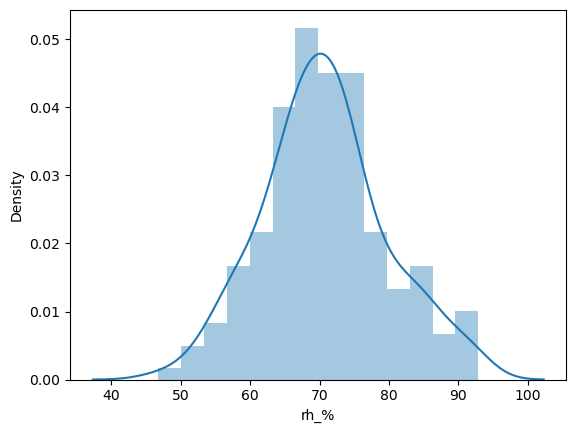

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


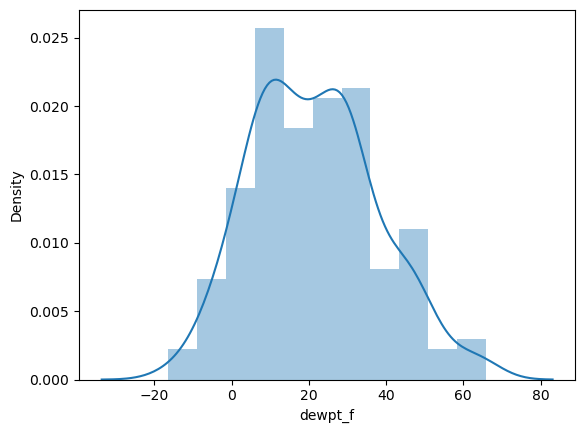

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


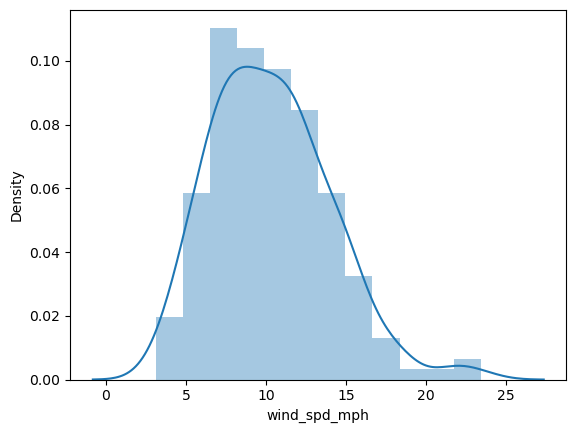

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


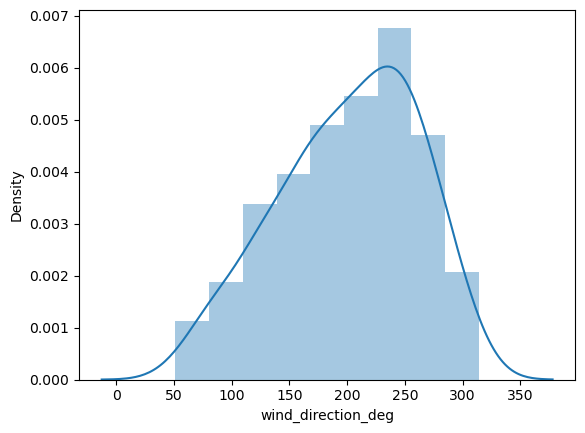

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


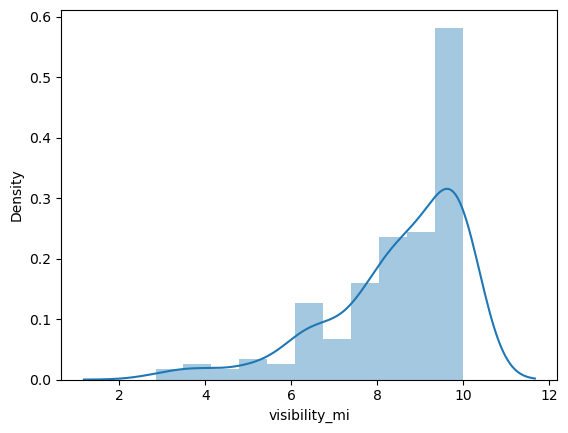

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


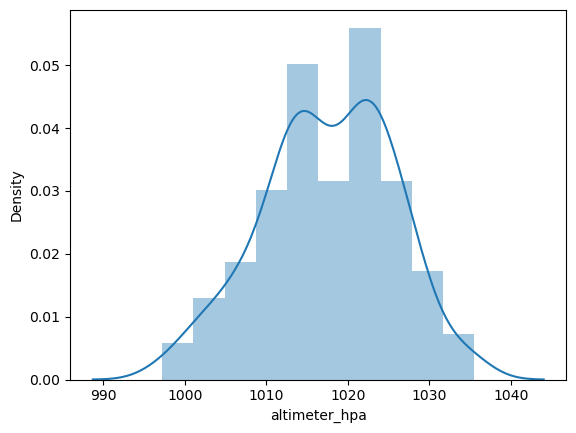

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


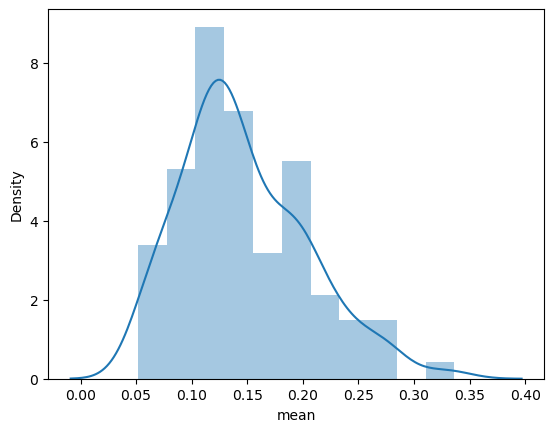

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


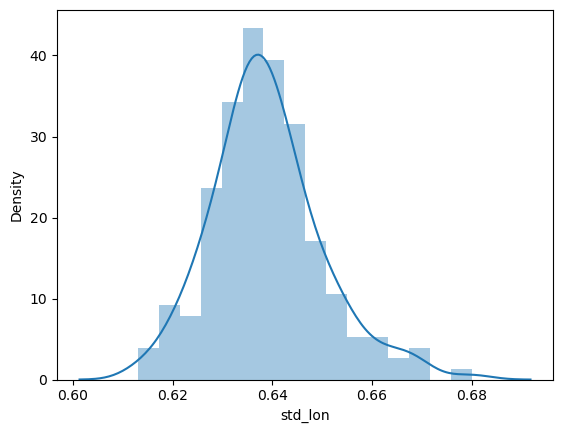

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


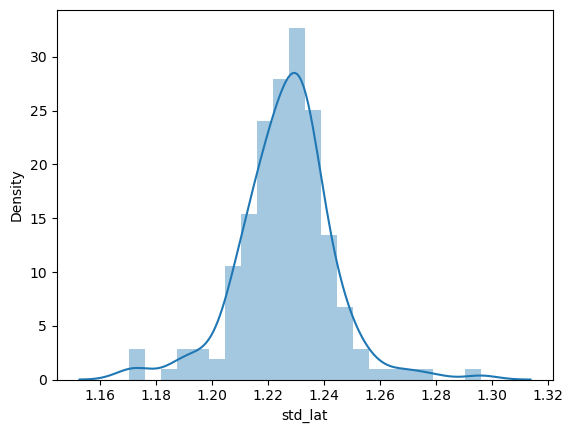

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


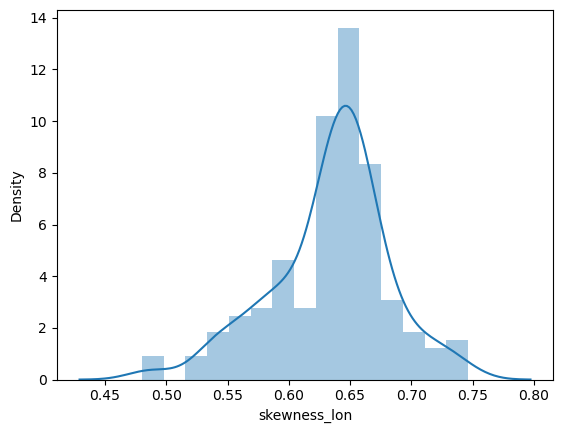

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


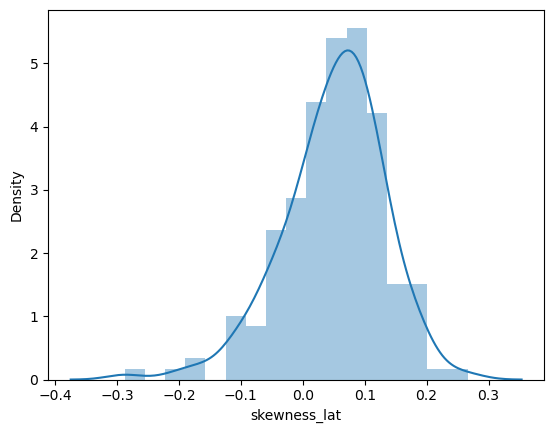

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


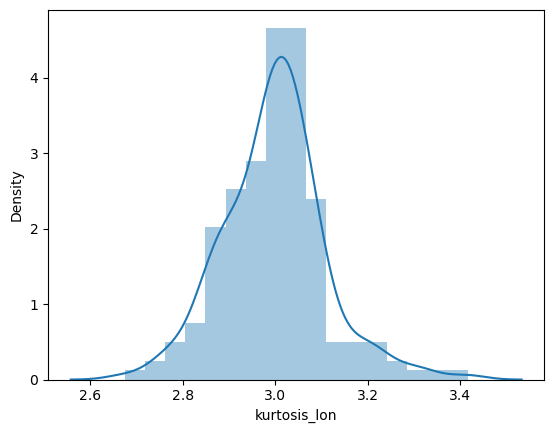

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


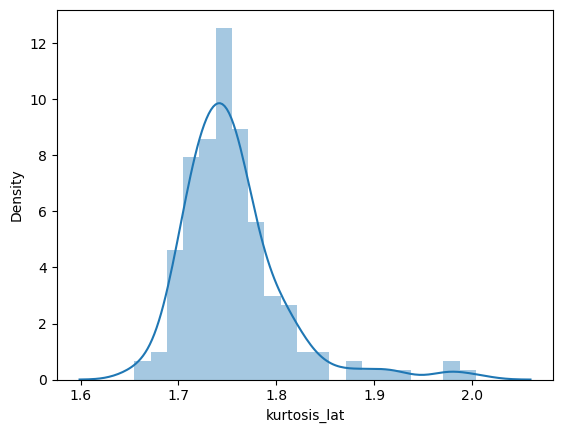

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


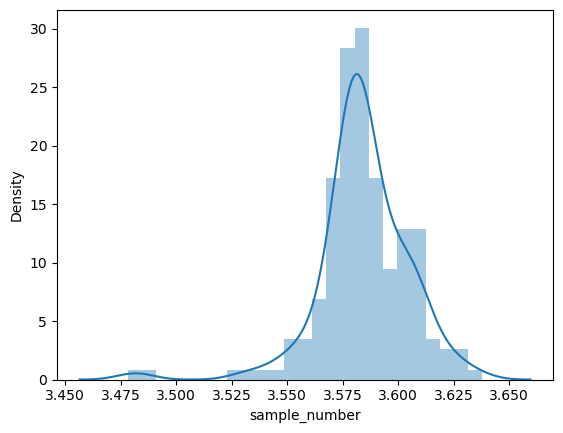

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


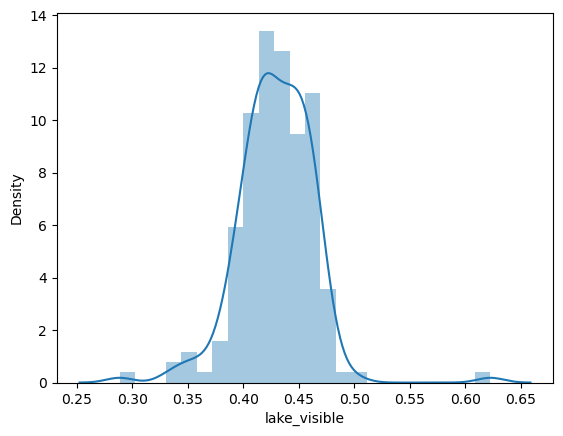

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


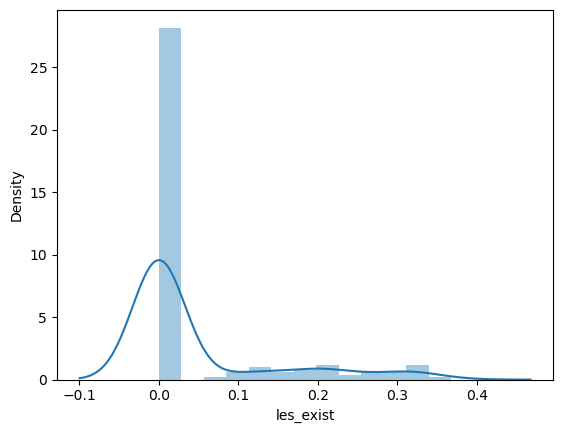

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


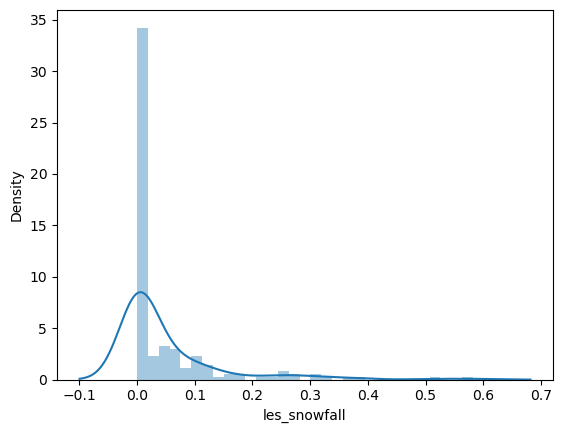

/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


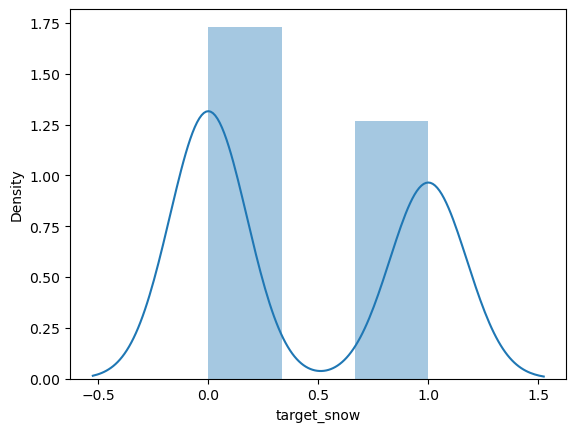

In [49]:
distPlot(grouped_df)

Now we can see that most of them are gaussian

## Shifting the dataframe

As we want to predict the snowfall some days in advance, we will shift the target column.

In [50]:
def shift_col(data, days):
    data3 = data.copy()
    data3['target_snow'] = data.target_snow.shift(-days)
    data3 = data3.dropna()
    data3 = data3.reset_index(drop=True)
    return data3

Shifting the target column by 3 days 

In [51]:
shifted_df = shift_col(grouped_df,3)
print(shifted_df.shape)
shifted_df.tail()

(179, 18)


,rh_%,dewpt_f,wind_spd_mph,wind_direction_deg,visibility_mi,altimeter_hpa,mean,std_lon,std_lat,skewness_lon,skewness_lat,kurtosis_lon,kurtosis_lat,sample_number,lake_visible,les_exist,les_snowfall,target_snow
174,56.895522,10.910448,7.074627,213.432836,9.791045,1023.447761,0.240393,0.644321,1.232032,0.643876,0.038499,2.977195,1.743056,3.611940,0.417910,0.0,0.014925,0.0
175,56.820896,11.402985,12.044776,299.253731,8.880597,1018.458209,0.228350,0.638121,1.214307,0.677113,0.086520,3.089059,1.790121,3.552239,0.447761,0.0,0.074627,0.0
176,50.847222,11.111111,9.125000,176.527778,9.972222,1022.512500,0.223560,0.619142,1.198320,0.662041,0.076173,3.208862,1.787105,3.583333,0.458333,0.0,0.000000,0.0
177,72.666667,32.043478,15.942029,178.840580,8.188406,1006.926087,0.116843,0.679939,1.296095,0.720921,0.183970,2.960778,1.696717,3.579710,0.463768,0.0,0.000000,0.0
178,76.439394,31.136364,12.545455,203.787879,9.015152,1013.039394,0.083335,0.667952,1.248616,0.646142,0.018104,2.902645,1.698702,3.590909,0.454545,0.0,0.000000,0.0


In [52]:
print(Counter(shifted_df['target_snow']))

Counter({0.0: 102, 1.0: 77})


## Declaring the feature set and target variable

In [53]:
shifted_df.columns

Index(['rh_%', 'dewpt_f', 'wind_spd_mph', 'wind_direction_deg',
       'visibility_mi', 'altimeter_hpa', 'mean', 'std_lon', 'std_lat',
       'skewness_lon', 'skewness_lat', 'kurtosis_lon', 'kurtosis_lat',
       'sample_number', 'lake_visible', 'les_exist', 'les_snowfall',
       'target_snow'],
      dtype='object')

In [54]:
X_dev = ['rh_%', 'dewpt_f', 'wind_spd_mph', 'wind_direction_deg',
       'visibility_mi', 'altimeter_hpa', 'mean', 'std_lon', 'std_lat',
       'skewness_lon', 'skewness_lat', 'kurtosis_lon', 'kurtosis_lat',
       'sample_number', 'lake_visible', 'les_exist']

In [55]:
X = pd.DataFrame(shifted_df , columns = X_dev)
print("Independant variables : ")
print(X.columns)
y = shifted_df['target_snow']
print("Dependant variable : target_snow")

Independant variables : 
Index(['rh_%', 'dewpt_f', 'wind_spd_mph', 'wind_direction_deg',
       'visibility_mi', 'altimeter_hpa', 'mean', 'std_lon', 'std_lat',
       'skewness_lon', 'skewness_lat', 'kurtosis_lon', 'kurtosis_lat',
       'sample_number', 'lake_visible', 'les_exist'],
      dtype='object')
Dependant variable : target_snow


In [56]:
# from sklearn import preprocessing
# X = preprocessing.scale(X)

## Splitting into train and test dataset

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [58]:
cnt = Counter(y_train)
cnt

Counter({0.0: 82, 1.0: 61})

In [59]:
cnt = Counter(y_test)
cnt

Counter({1.0: 16, 0.0: 20})

## Naive Bayes

In [60]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [61]:
from sklearn.metrics import confusion_matrix, accuracy_score

pred = nb.predict(X_test)
cm = confusion_matrix(pred, y_test)
cm

array([[13,  3],
       [ 7, 13]])

In [62]:
accuracy_score(pred, y_test)

0.7222222222222222

Wow! Accuracy increased from 66% to 72%

## Decision Tree

In [63]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
pred = dt.predict(X_test)

print(confusion_matrix(pred, y_test))
accuracy_score(pred, y_test)

[[14  5]
 [ 6 11]]


0.6944444444444444

## Random Forest

In [64]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print(confusion_matrix(pred, y_test))
accuracy_score(pred, y_test)

[[17  4]
 [ 3 12]]


0.8055555555555556

# Conclusion 2
When we group the rows by date we get a better accuracy with Naive Bayes, this might be because we take mean of all other features while grouping the data and means tend to follow the gaussian distribution.

Further we also tried to see if dimensionality reduction was possible on the dataset

## Determinant of covariance matrix

In [65]:
print("determinant of cov. matrix with 18 features : %.30f" % np.linalg.det(grouped_df.cov())) 

determinant of cov. matrix with 18 features : 0.000000000000000000000001863827


Ok, so this means our data does not occupy all of 18-dimensional space, and we can afford to do dimenstionality reduction. Put in other words, our data is redundant.

Normalizing the data

In [66]:
def data_normalize(data):
    a = map(lambda i :(data.iloc[:,i] - np.mean(data.iloc[:,i]))/np.std(data.iloc[:,i]), np.arange(len(data.columns)))
    return pd.DataFrame(list(a)).T

In [67]:
from sklearn.decomposition import PCA

def pca(data,c):
    pca = PCA( n_components = c)
    x = pca.fit_transform(data)
    return pd.DataFrame(x) , pca

X_train_pca, pca_obj = pca(data_normalize(X_train) , 15)
print("determinant of cov. matrix with 15 features : %.30f" % np.linalg.det(X_train_pca.cov()))  # Determinant

determinant of cov. matrix with 15 features : 0.003490012060227021088720800179


So 15 features could be a good choice of feature for predicting the model.

In [68]:
X_test_pca, pca_obj = pca(data_normalize(X_test) , 15)

## Naive Bayes with PCA

In [69]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_pca, y_train)

GaussianNB()

In [70]:
from sklearn.metrics import confusion_matrix, accuracy_score

pred = nb.predict(X_test_pca)
cm = confusion_matrix(pred, y_test)
cm

array([[12,  8],
       [ 8,  8]])

In [71]:
accuracy_score(pred, y_test)

0.5555555555555556

We see that the accuracy drops a lot. So using PCA is causing information loss hence this is not reccomended with Naive Bayes